In [203]:
import requests
import matplotlib.pyplot as plt
import os
import re

In [204]:
api_addr = "http://141.56.137.185:5000"

In [205]:
def api_sql_execute(sql):
    try:
        response = requests.get(api_addr+"/hub/"+sql, headers={'Content-Type': 'application/json'})
        result = response.json()
        
        if not response.ok:
            raise Exception(f"HTTP error! status: {result.get('error', response.status_code)}")
        
        return result, False

    except Exception as e:
        return e, True

In [206]:
def api_sql_schema():
    try:
        response = requests.get(api_addr+"/schema", headers={'Content-Type': 'application/json'})
        result = response.json()
        
        if not response.ok:
            raise Exception(f"HTTP error! status: {result.get('error', response.status_code)}")
        
        return result, False

    except Exception as e:
        return e, True

### DB Schema

In [207]:
res, error = api_sql_schema()
if not error:
    print(res.replace('\\r\\n', '\n'))
else:
    print(res)

PRAGMA foreign_keys = ON;

CREATE TABLE IF NOT EXISTS t_category (
    c_id INTEGER PRIMARY KEY AUTOINCREMENT,
    c_category TEXT NOT NULL UNIQUE
);

CREATE TABLE IF NOT EXISTS t_model (
    c_id INTEGER PRIMARY KEY AUTOINCREMENT,
    c_model TEXT NOT NULL UNIQUE
);

CREATE TABLE IF NOT EXISTS t_input (
    c_id INTEGER PRIMARY KEY AUTOINCREMENT,
    c_input TEXT NOT NULL UNIQUE,
    c_rule TEXT,
    c_temperature DECIMAL NOT NULL,
    c_note TEXT,
    t_category_id INTEGER NOT NULL,
    FOREIGN KEY (t_category_id) REFERENCES t_category(c_id)
);

CREATE TABLE IF NOT EXISTS t_output (
    c_id INTEGER PRIMARY KEY AUTOINCREMENT,
    c_output_think TEXT,
    c_output_final TEXT,
    c_total_duration INTEGER NOT NULL,
    c_load_duration INTEGER NOT NULL,
    c_prompt_eval_count INTEGER NOT NULL,
    c_prompt_eval_duration INTEGER NOT NULL,
    c_eval_count INTEGER NOT NULL,
    c_eval_duration INTEGER NOT NULL,
    c_score DECIMAL NOT NULL,
    c_note TEXT,
    t_input_id INTEGER NOT NUL

### Analyse

In [208]:
img_index = 0
os.makedirs('plot', exist_ok=True)
def show_plot(labels, data, title):
    global img_index
    total = sum(data)
    plt.figure(figsize=(8, 5))
    plt.bar(labels, data, color='skyblue')
    plt.xlabel('Score')
    plt.ylabel('Sum')
    plt.title('Distribution of scores' + title + f"\nTotal Data: {total}")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    safe_title = re.sub(r'[^a-zA-Z0-9_-]', '_', title)
    plt.savefig(f'plot/{safe_title}.png')
    plt.show()
    img_index += 1

In [ ]:
def get_score(rules):
    labels_array = []
    results_array = []
    where_clauses = [f"{k} = '{v}'" for rule in rules for k, v in rule.items()]
    where_filter = " AND " + " AND ".join(where_clauses) if where_clauses else ""
    for score in range(1, 6):
        sql = f"""
            SELECT COUNT(*) FROM t_output
            join t_input on t_input.c_id = t_output.t_input_id 
            join t_model on t_model.c_id = t_output.t_model_id
            join t_category on t_category.c_id = t_input.t_category_id
            WHERE c_score = {score}{where_filter};
        """
        res, error = api_sql_execute(sql)
        labels_array.append(score)
        results_array.append(res)
    return labels_array, [row[0]['COUNT(*)'] for row in results_array]

In [210]:
res_models, error = api_sql_execute('SELECT * FROM t_model')
res_categories, error = api_sql_execute('SELECT * FROM t_category')

#ids_model = [item['c_id'] for item in res]
#models = [item['c_model'] for item in res]

### Score of each Model

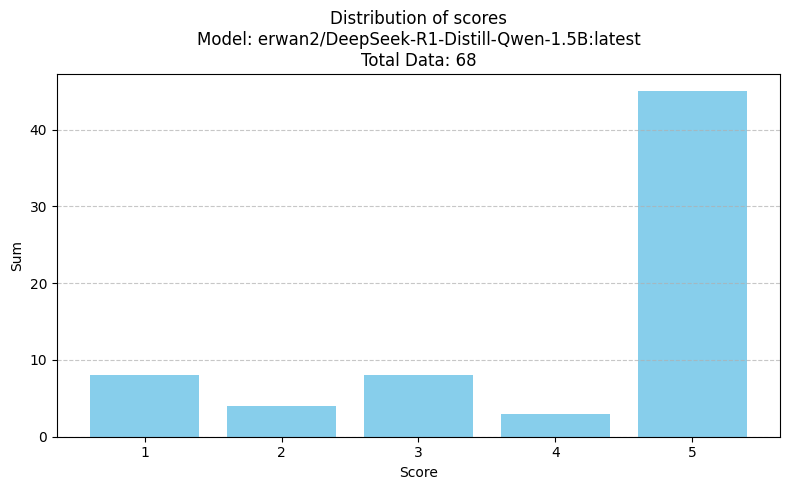

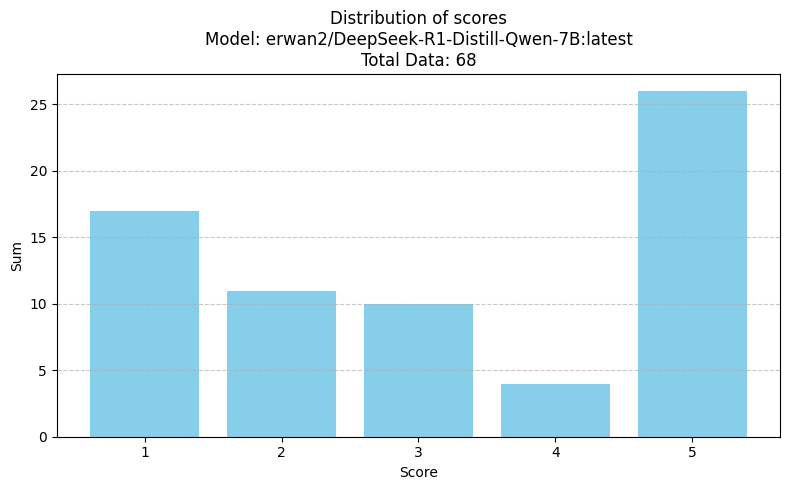

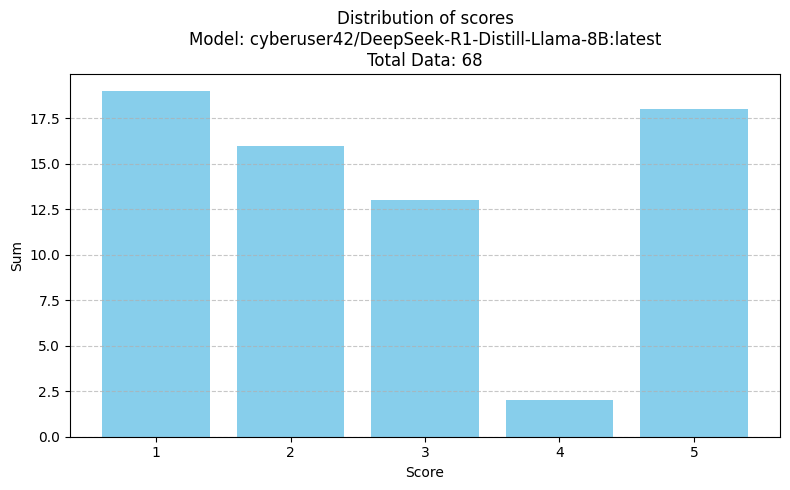

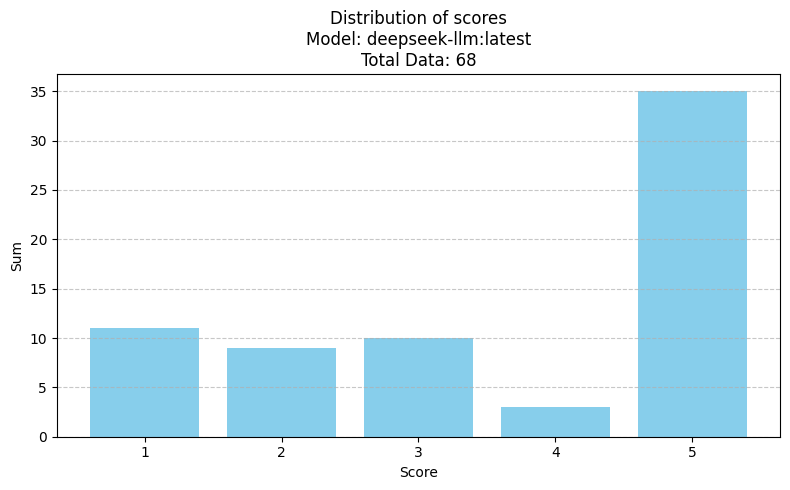

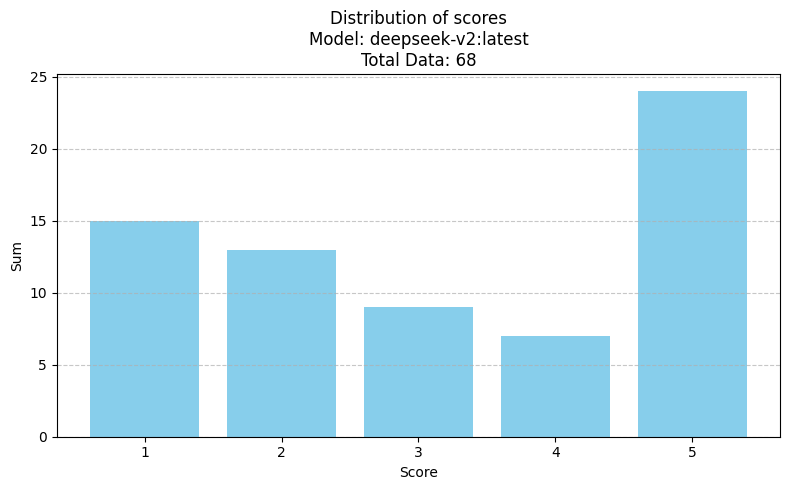

In [211]:
for res_model in res_models:
    id_model = res_model['c_id']
    model = res_model['c_model']
    labels, data = get_score([{'t_model.c_id':id_model}])
    show_plot(labels, data, f'\nModel: {model}')

### Score of each Category

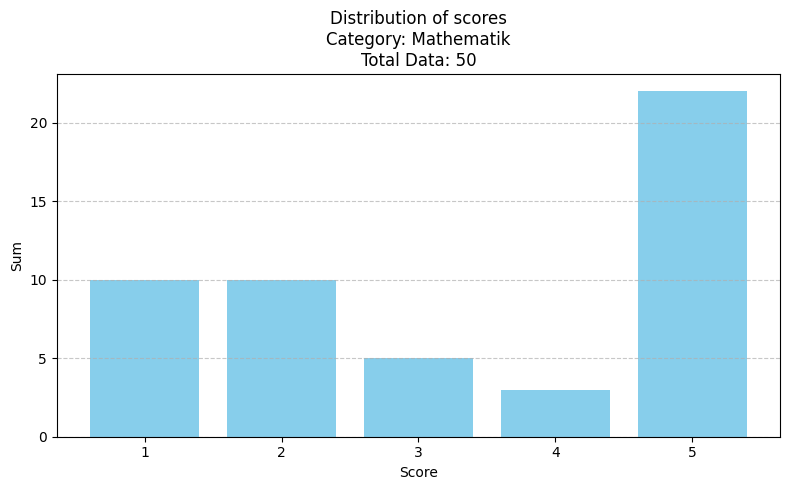

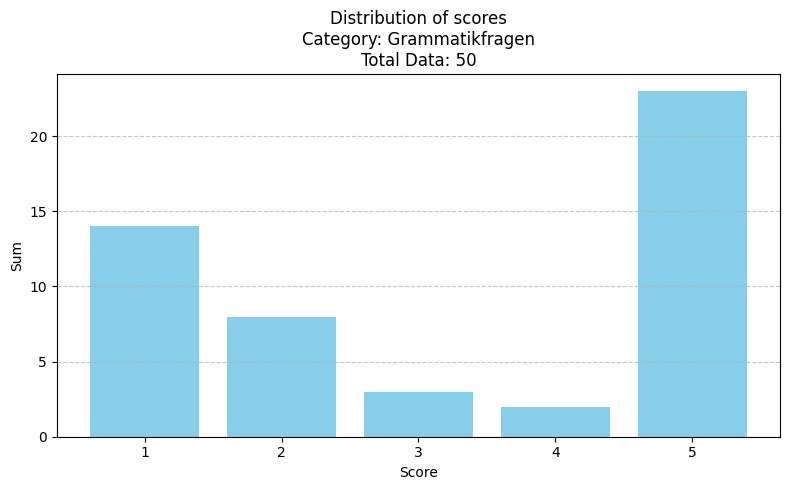

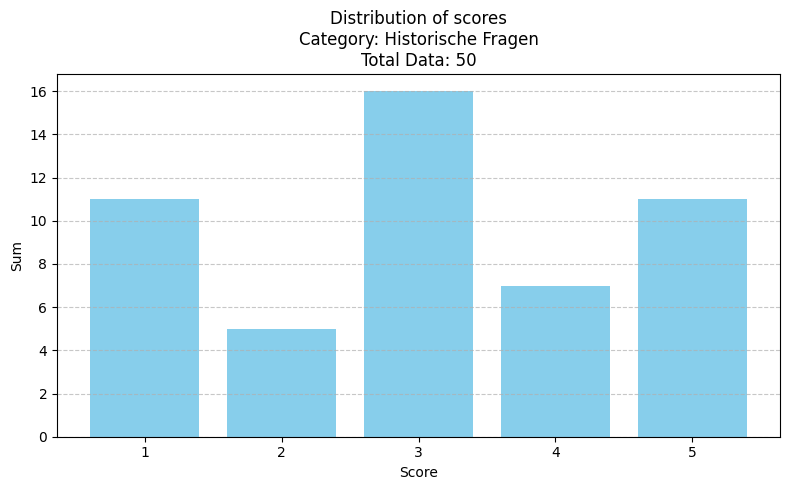

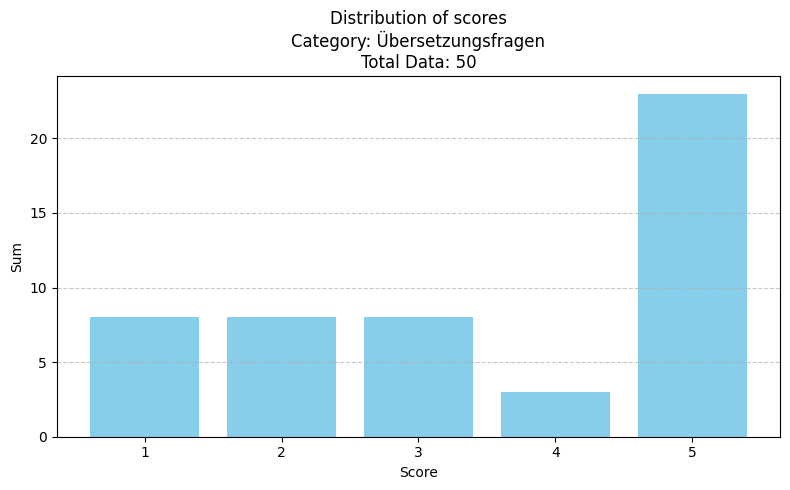

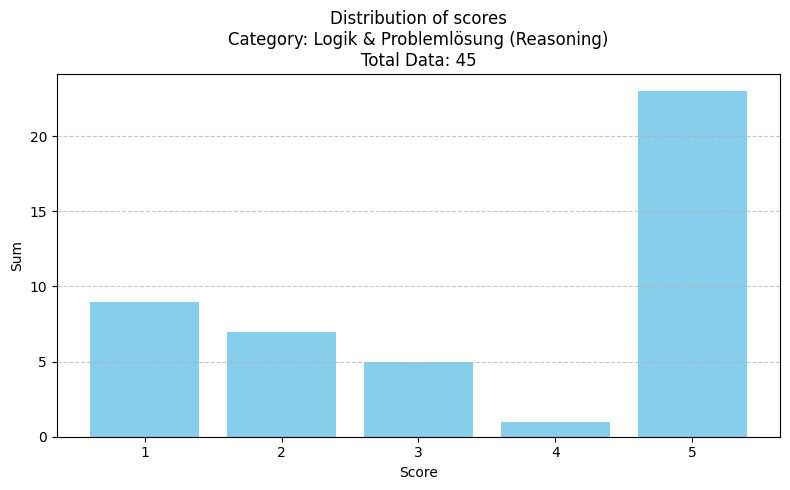

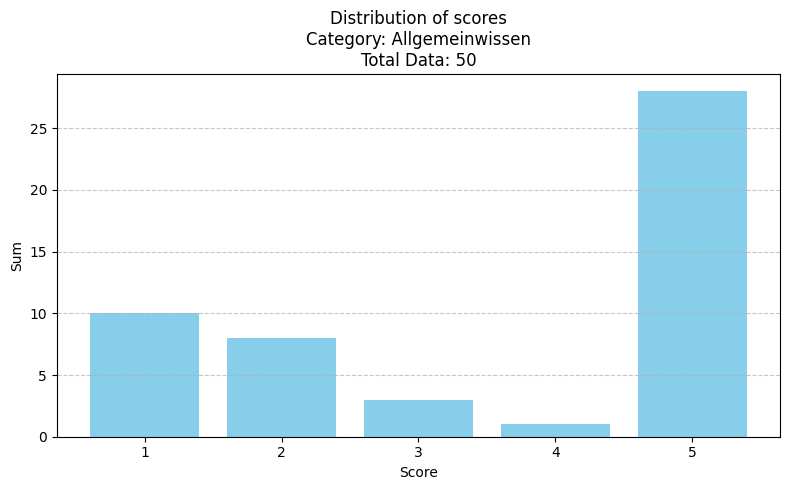

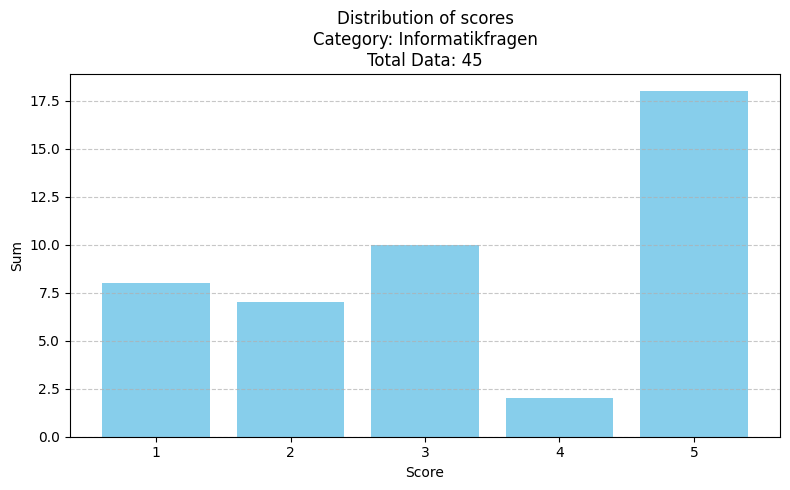

In [212]:
for res_category in res_categories:
    id_category = res_category['c_id']
    category = res_category['c_category']
    labels, data = get_score([{'t_category.c_id':id_category}])
    show_plot(labels, data, f'\nCategory: {category}')

### Score of each Model and Category

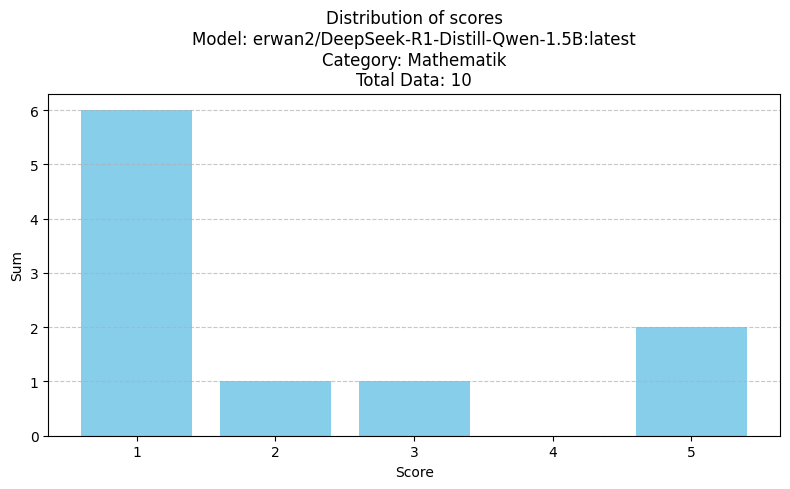

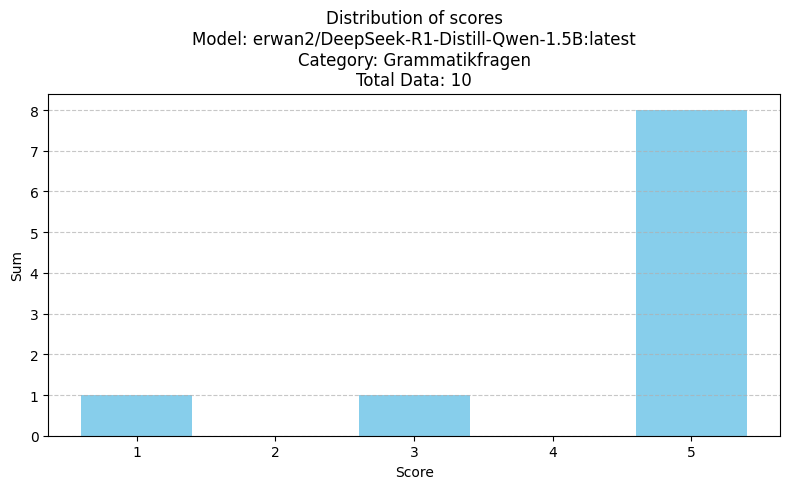

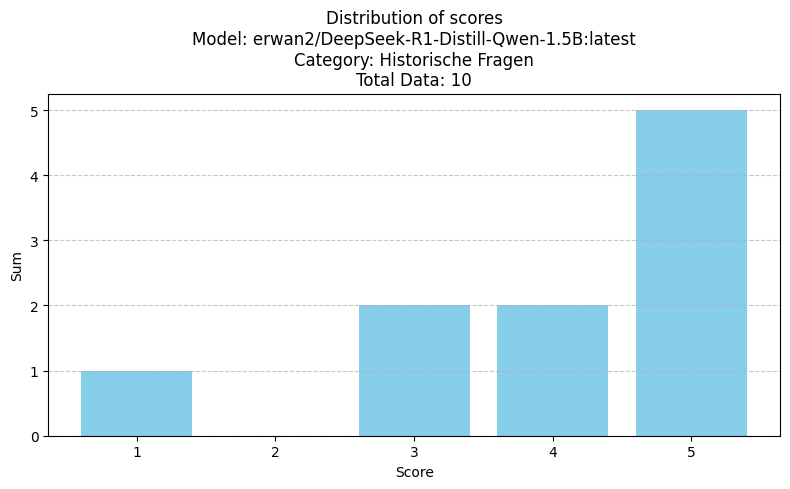

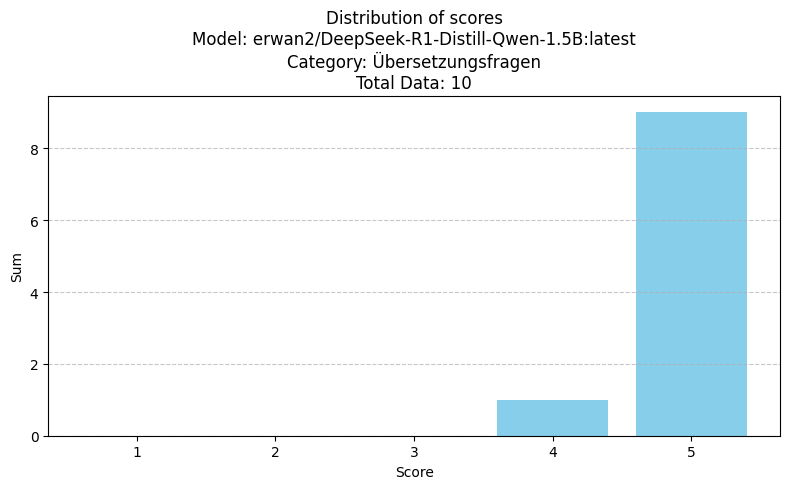

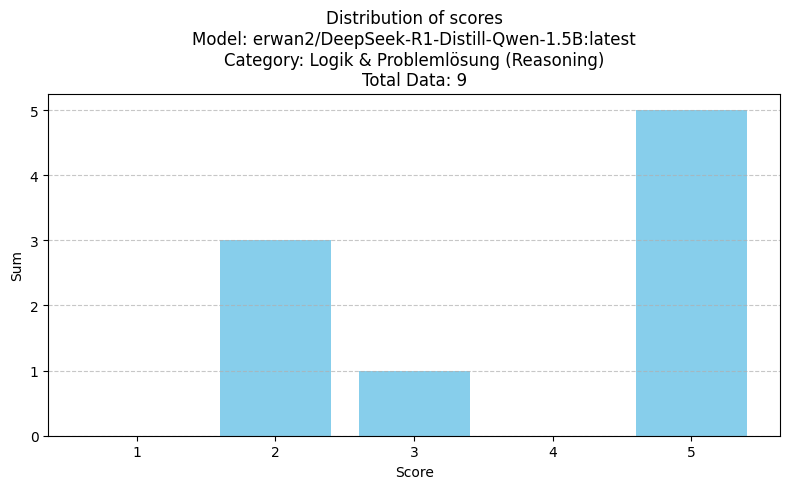

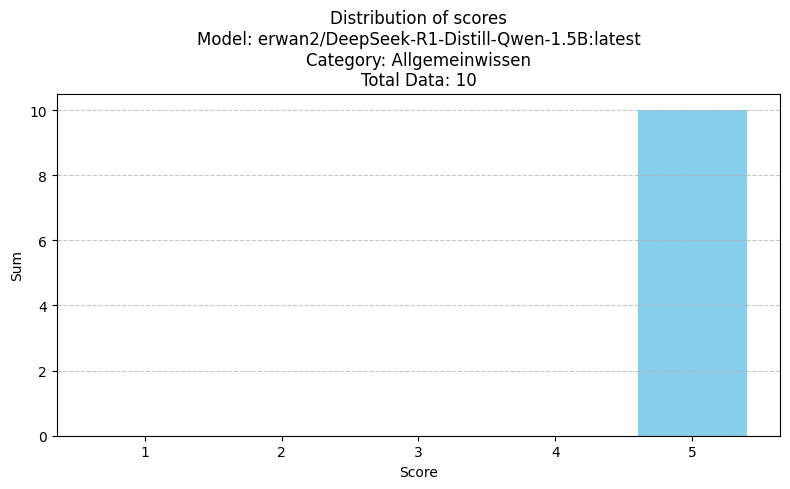

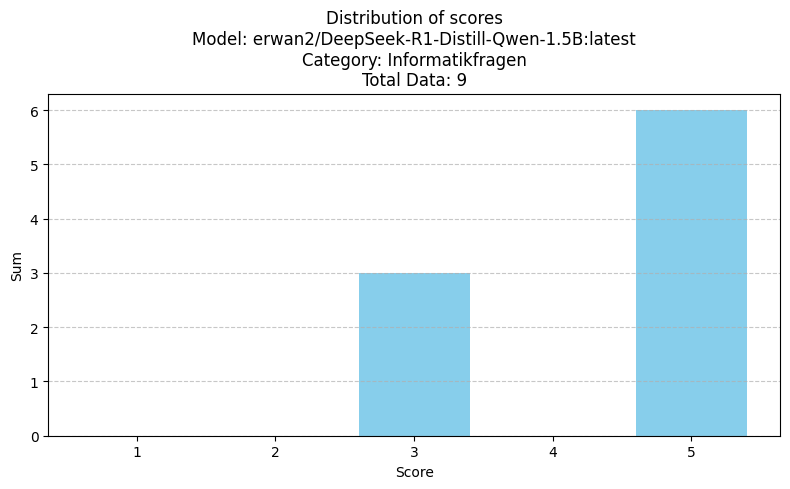

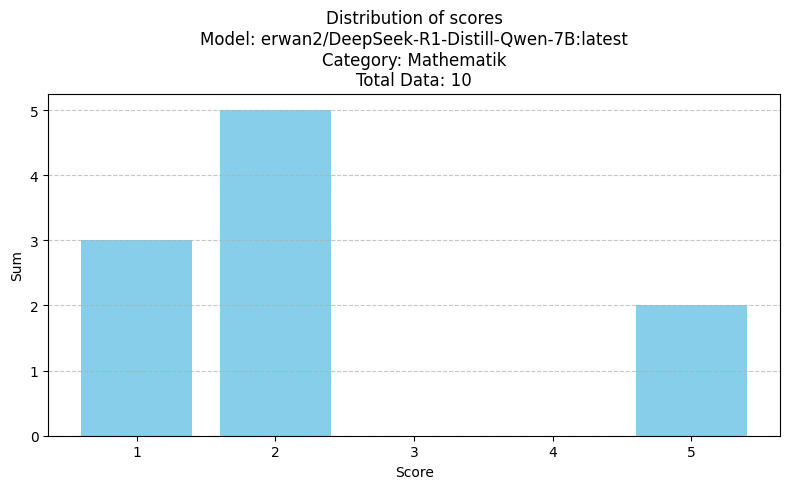

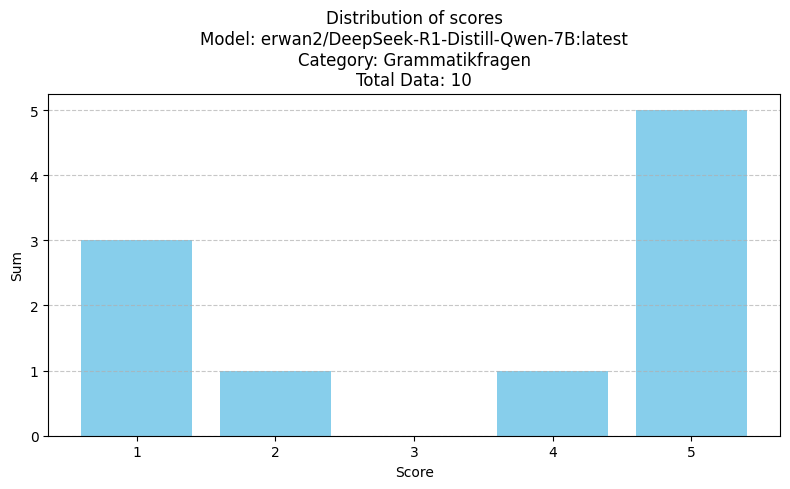

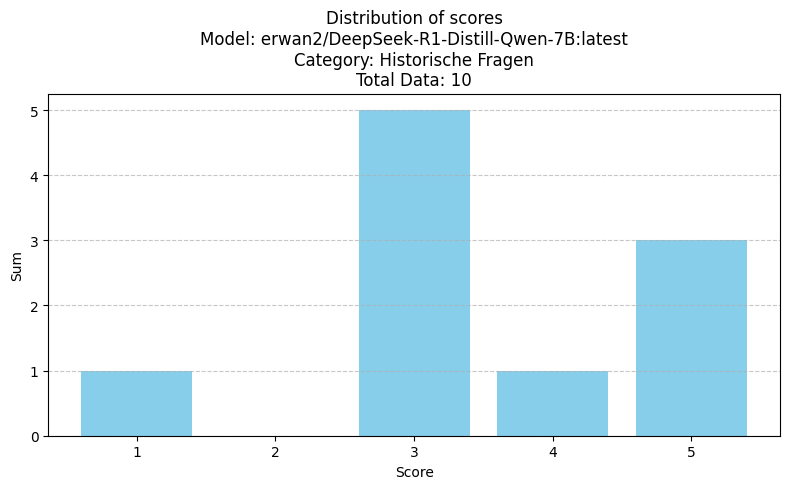

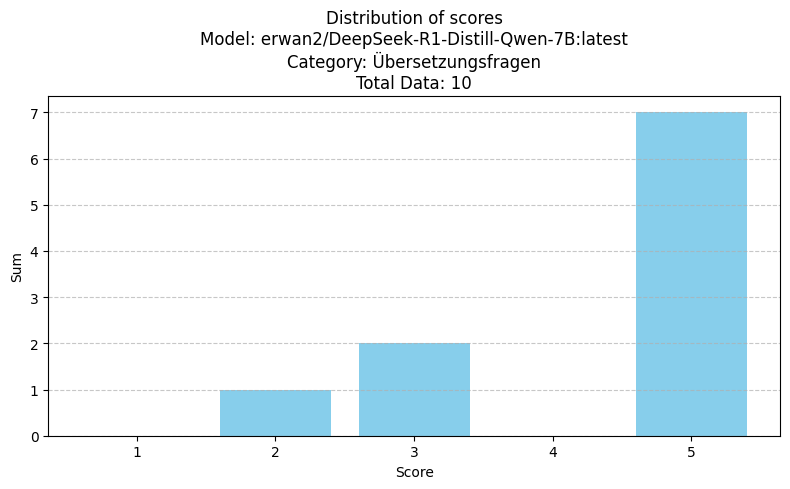

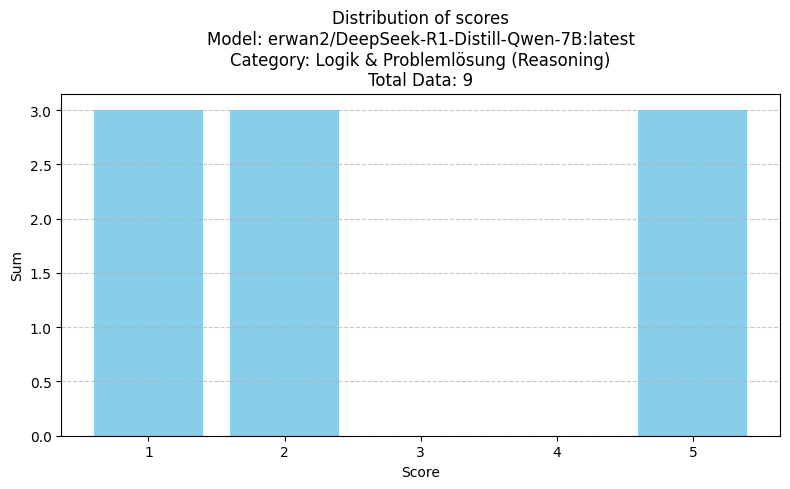

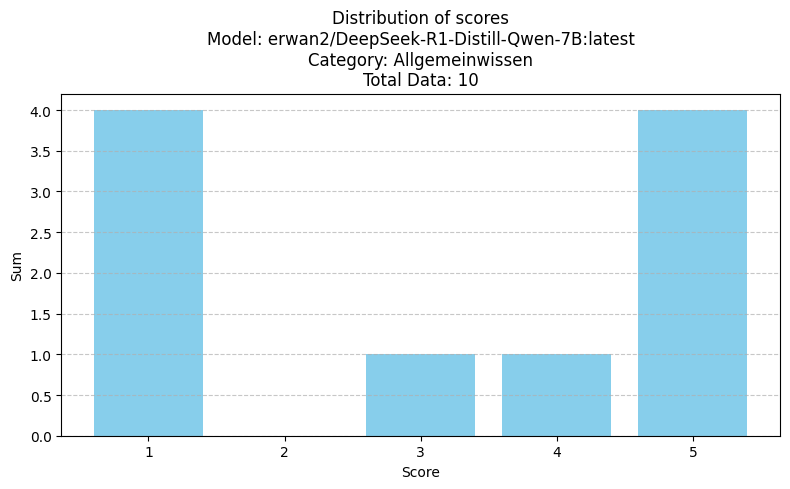

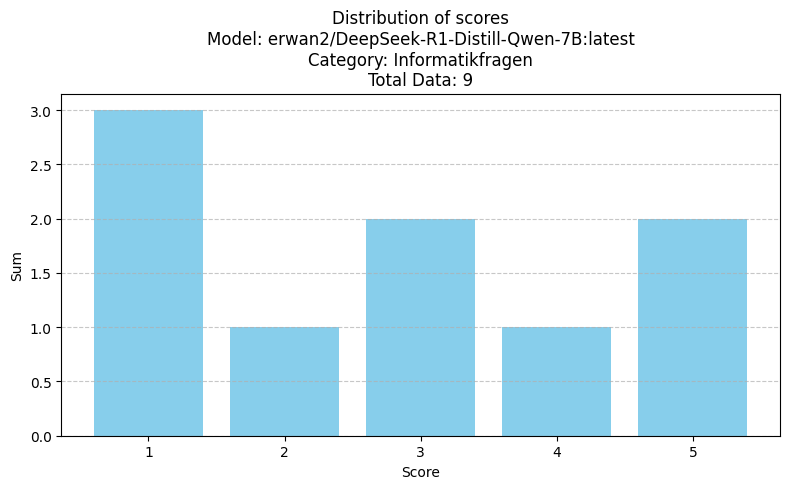

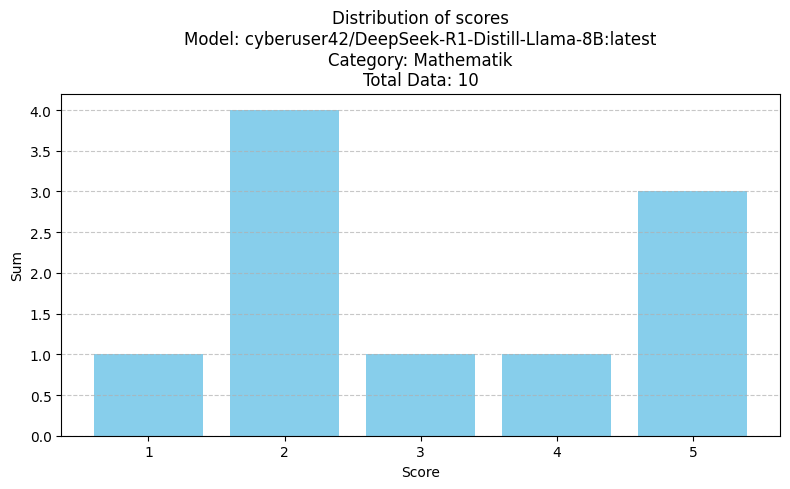

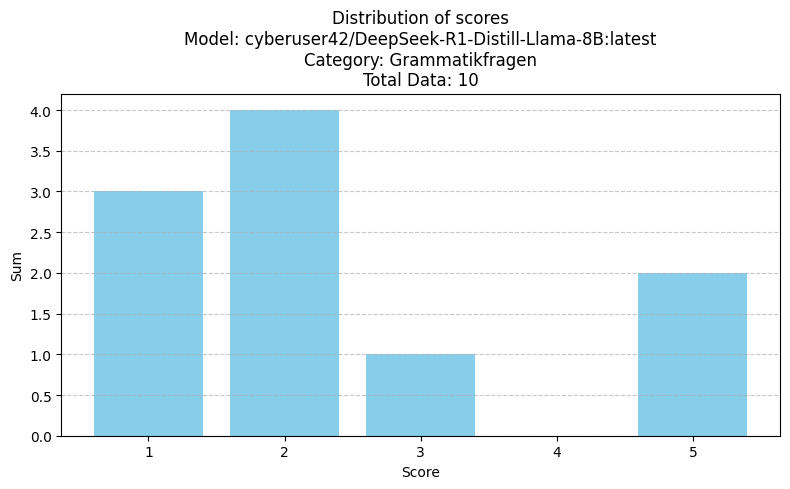

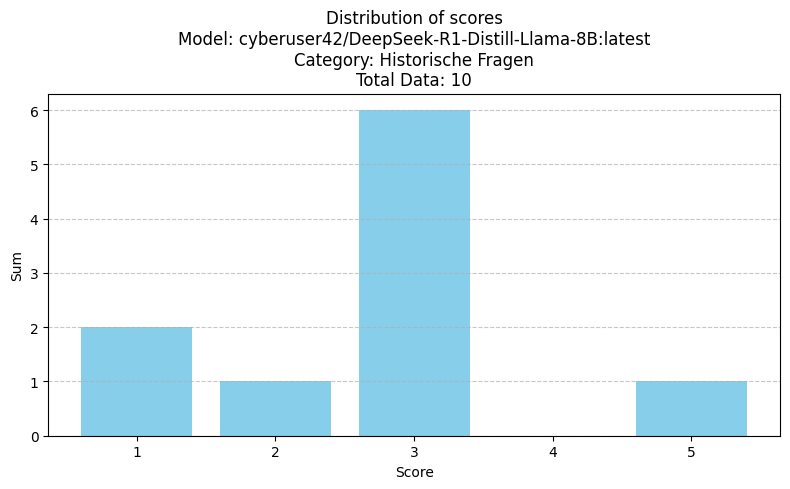

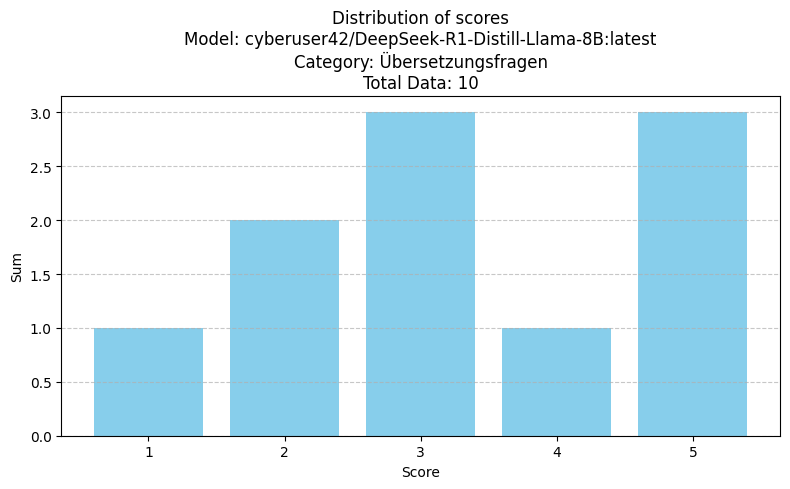

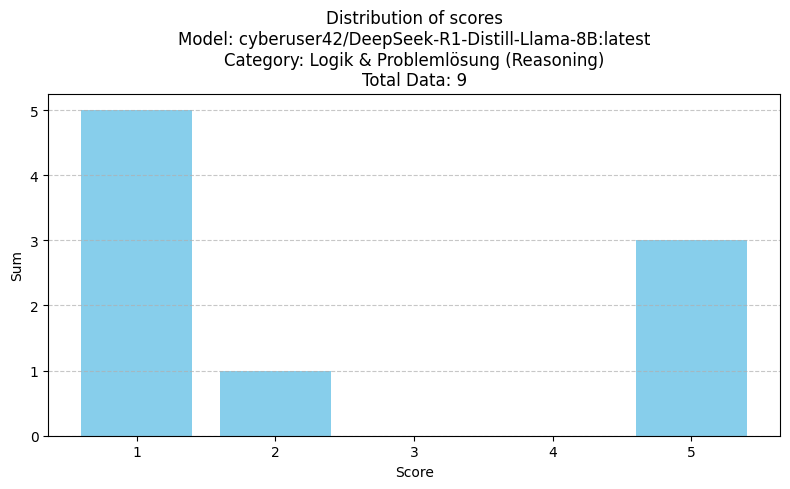

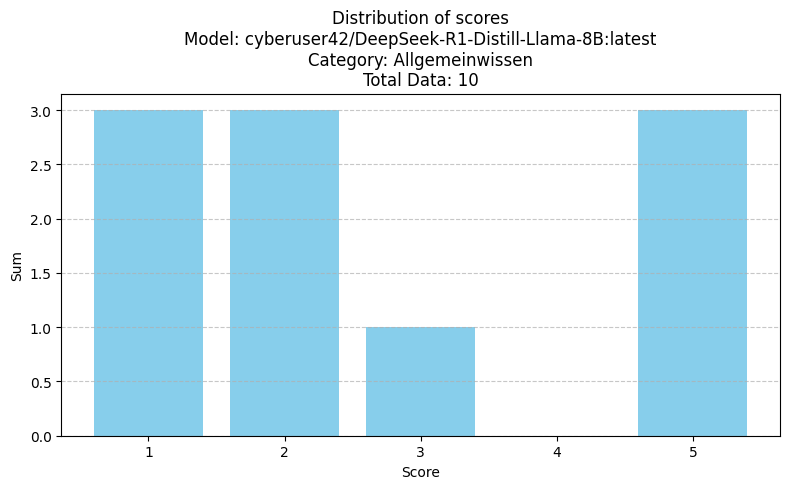

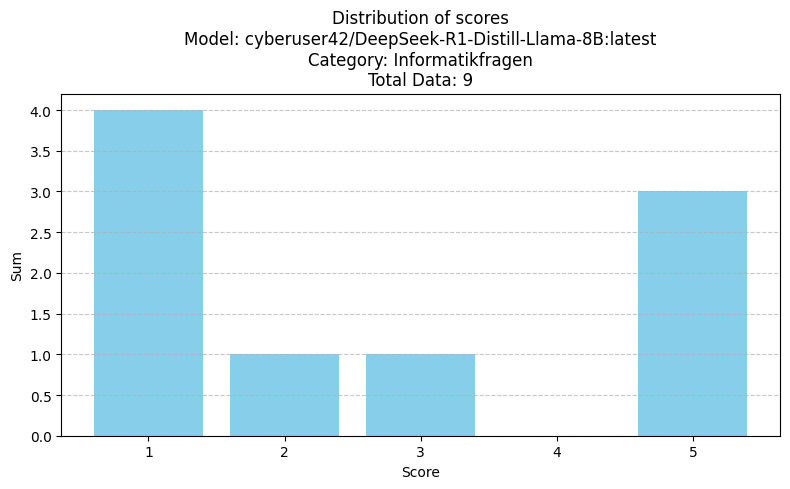

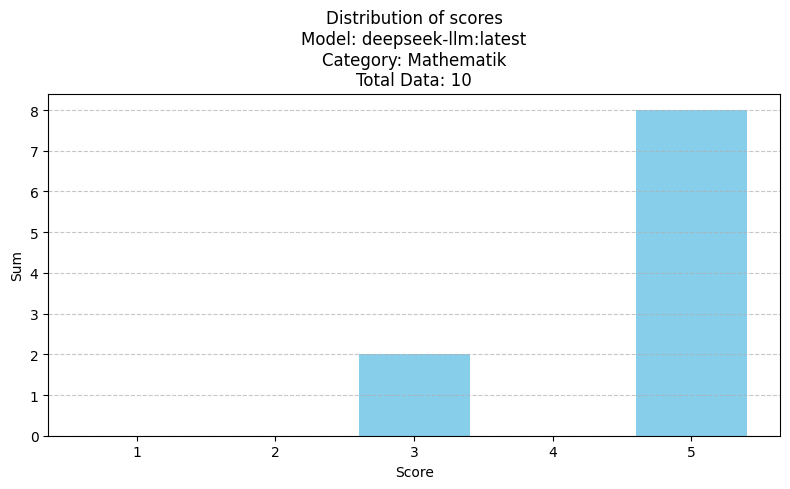

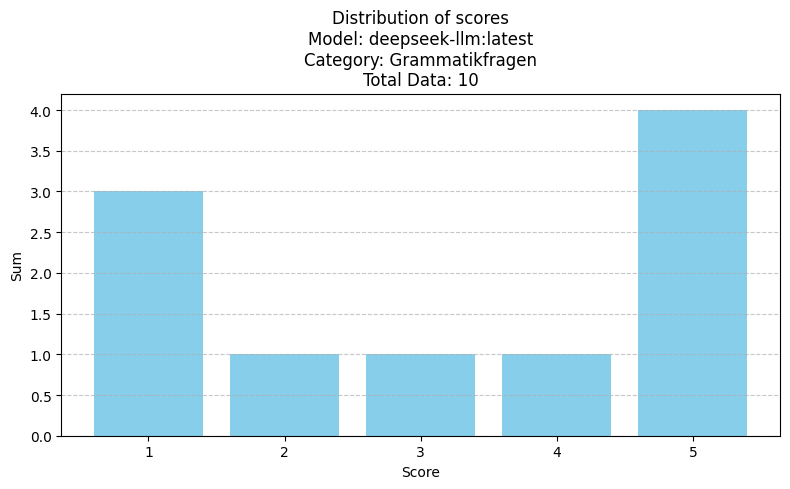

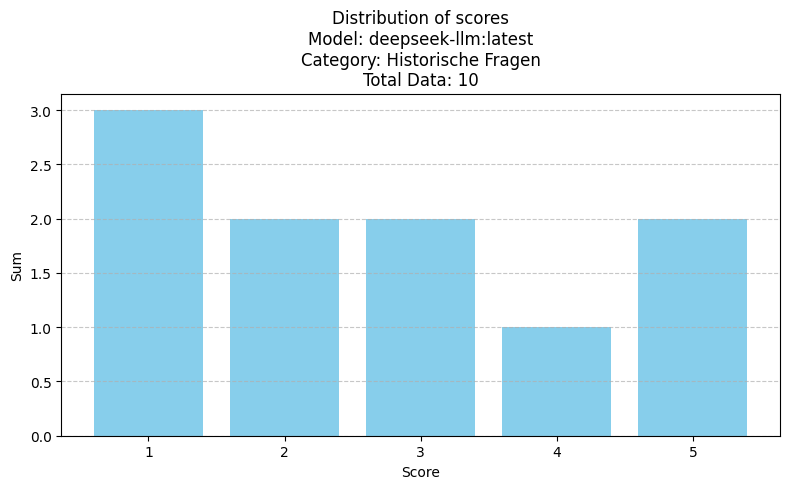

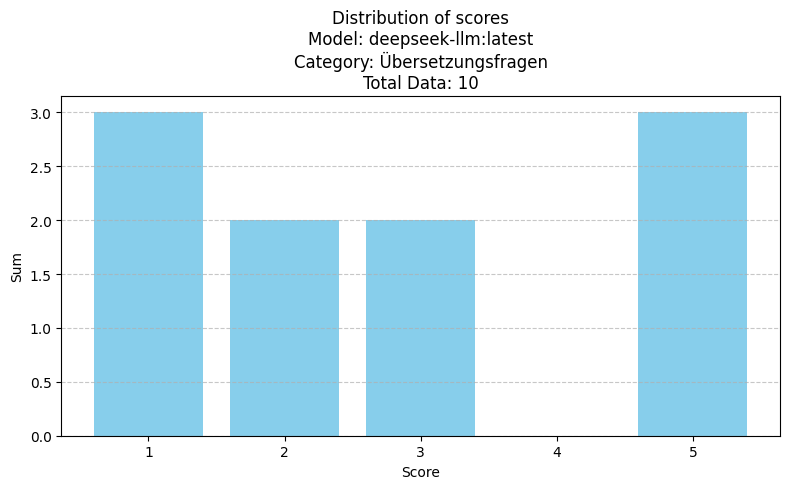

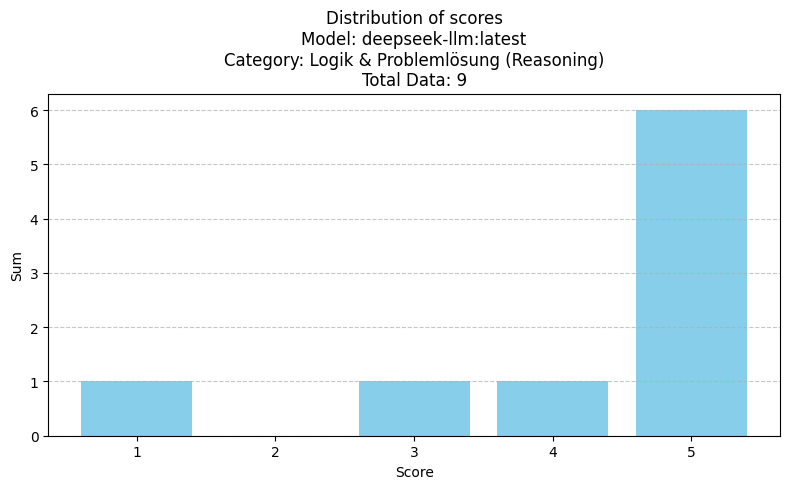

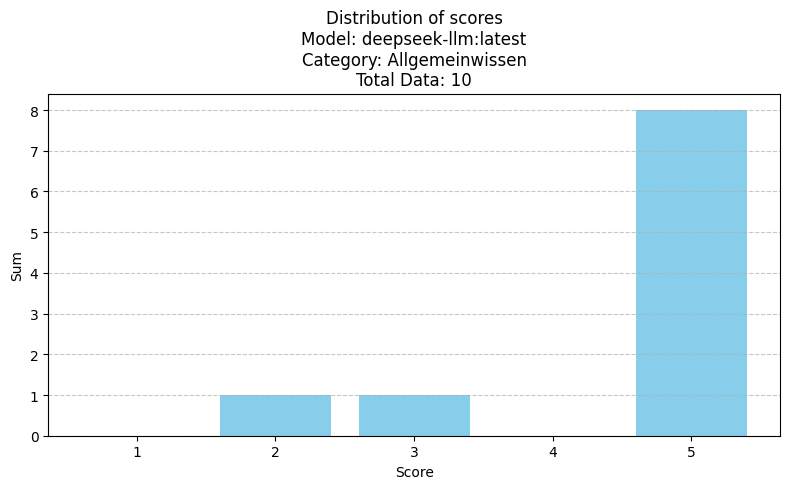

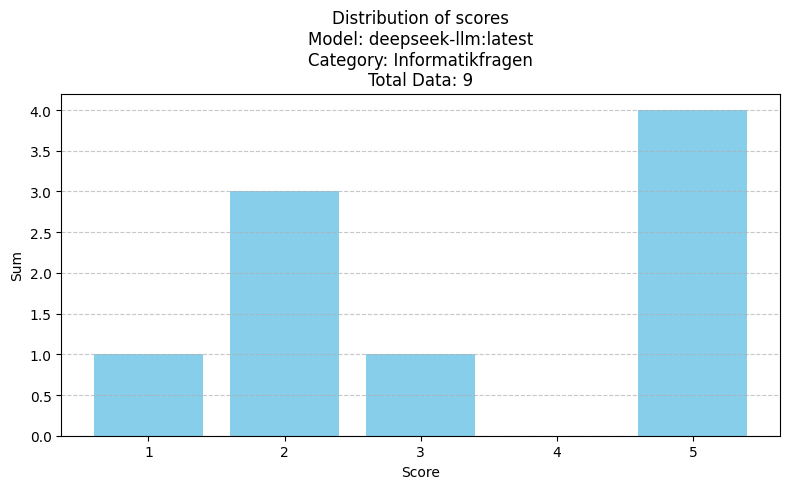

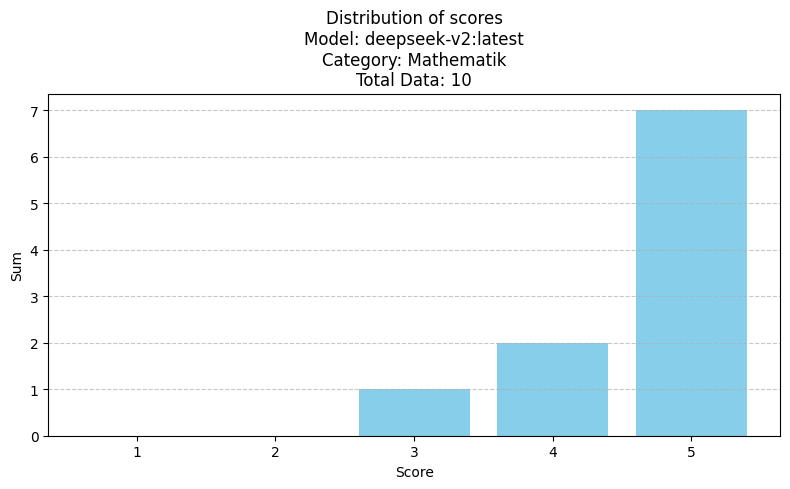

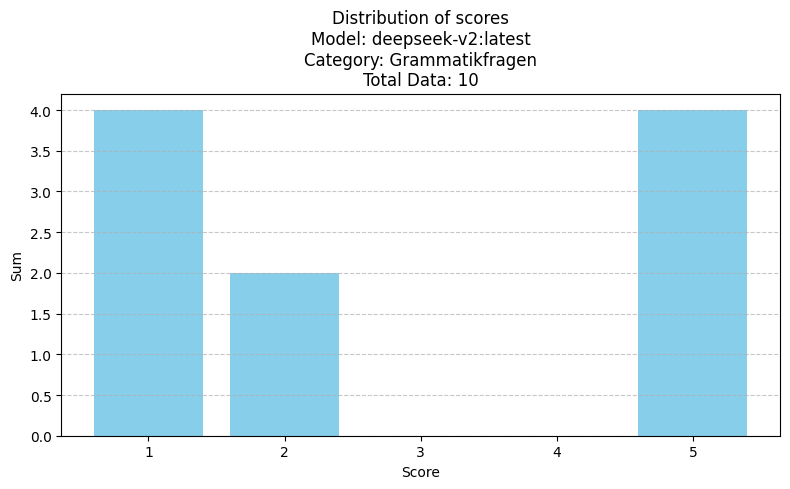

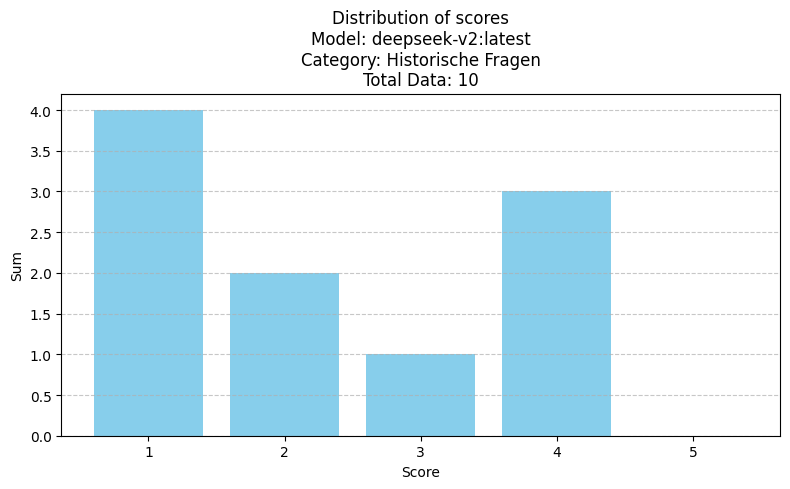

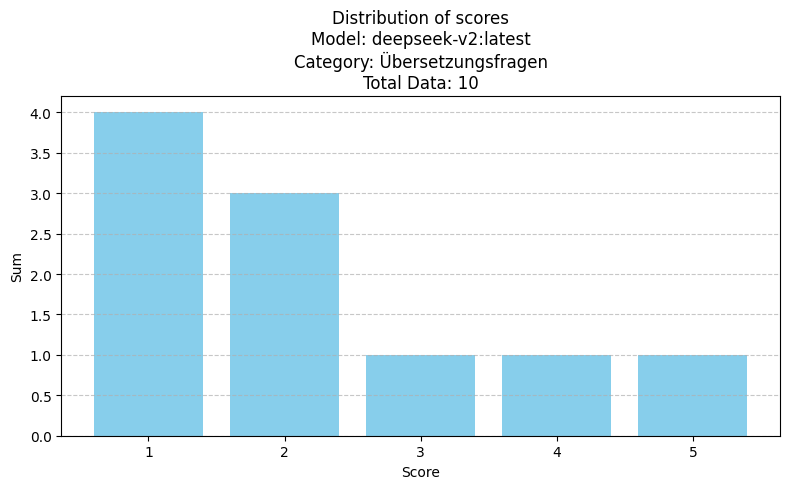

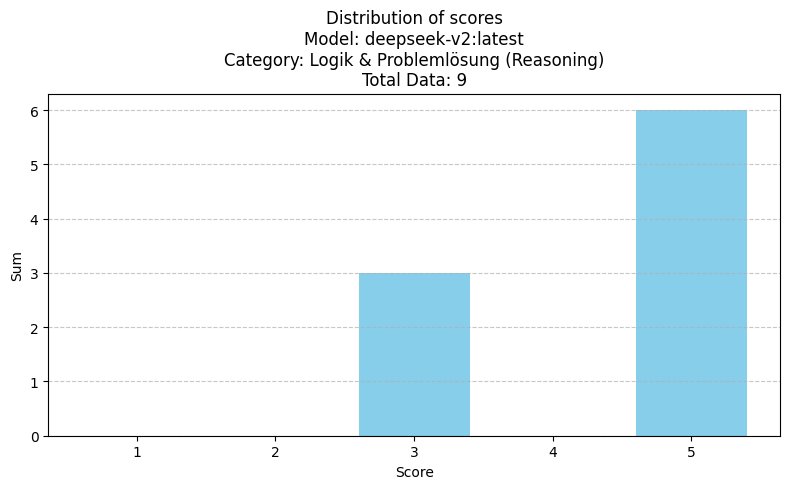

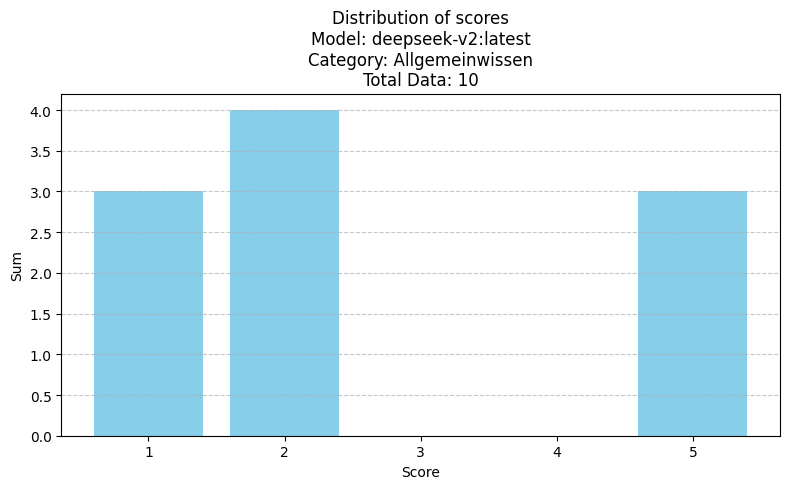

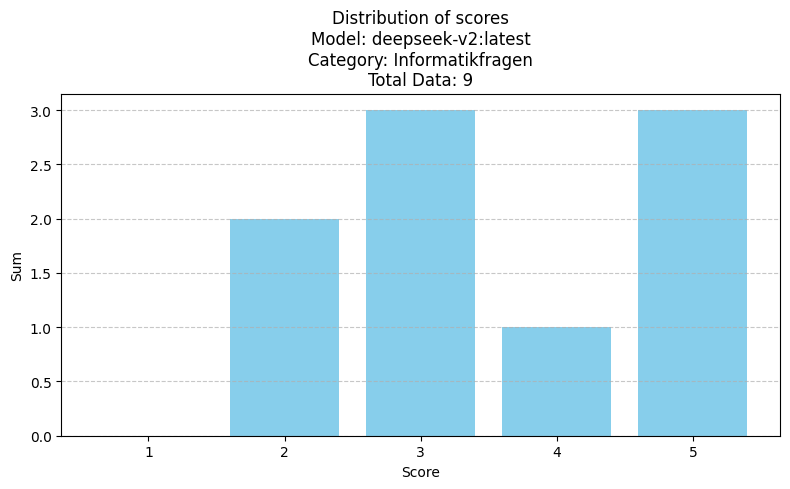

In [213]:
for res_model in res_models:
    id_model = res_model['c_id']
    model = res_model['c_model']
    for res_category in res_categories:
        id_category = res_category['c_id']
        category = res_category['c_category']
        labels, data = get_score([{'t_model.c_id':id_model}, {'t_category.c_id':id_category}])
        show_plot(labels, data, f'\nModel: {model}\nCategory: {category}')